<h1>NetworkX Demo</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *
import lda_utils as utils

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [2]:
ms2lda = Ms2Lda.resume_from('results/beer2pos_rerun.project')

Project loaded from results/beer2pos_rerun.project time taken = 35.221818924
 - input_filenames = 
	../input/final/Beer2pos_MS1filter_Method3_fragments.csv
	../input/final/Beer2pos_MS1filter_Method3_losses.csv
	../input/final/Beer2pos_MS1filter_Method3_ms1.csv
	../input/final/Beer2pos_MS1filter_Method3_ms2.csv
 - df.shape = (1567, 4975)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Tue Dec 22 20:40:56 2015
 - message = Re-running LDA and storing the Z


In [3]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Specify the list of motifs of interest below. 

In [4]:
annot_file = 'results/beer2pos_annotation_Nov2015.csv'
motif_annotation, motif_idx = load_motif_annotation(annot_file, True)
motifs_of_interest = motif_annotation.keys()   

65	Small nitrogen containing abundant fragment ion - often proline or ornithine derived
182	Water loss - indicative of a free hydroxyl group
208	Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
168	Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure
89	Leucine substructure
268	Conjugation of a phosphate group (H4O4P) substructure
46	Losses indicative of a hexose with NH2 group
297	Losses indicative of a hexose with NH2 group
37	Fragments possibly indicative for N-Methyl-oxo-pyrrolidinecarboxylic acid like structure
63	Pyroglutamic acid (pyroglutamate) substructure
61	Amine loss - suggests free NH2 group in fragmented molecule
45	Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars
90	[proline-H2O] suggests conjugated proline substructure
136	Loss possibly indicative of carboxylic acid group with 1-carbon attached
81	Imidazole group linked to a carboxylgroup thro

In [5]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 261 motifs from the graph because they're not in the list
Removed [] from the graph because they don't share documents with other motifs in the list
Removed 407 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 1199
Number of edges: 1793
Average degree:   2.9908


So, when we create the graph *G*, we also filtered it in such a way that (1) only the motifs in the provided list are retained and additionally, (2) these motifs must have some documents shared with another motif.

Next, we draw a bipartite graph where the left side is the MS1 peaks (labelled by their peak ids) and the right side are the M2Ms. The graph has been filtered such that we only show MS1 peaks that are connected to at least *min_degree* number of Mass2Motifs. 

The number beside each motif (e.g. +25) shows how many other MS1 connected to it that we are not showing because there's no overlap with other motifs in the list.

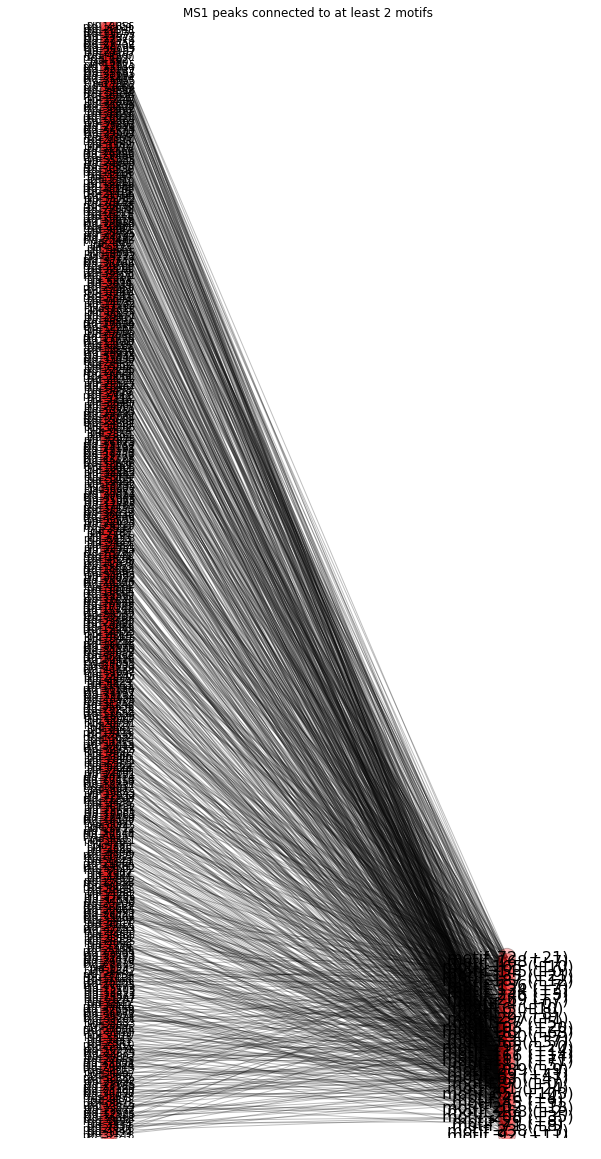

In [6]:
doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=2, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

# can tweak the fig_ and spacing_ parameters to adjust the plot appearance, especially if graph is dense
# doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=3, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

We can also plot the fragmentation spectra of these MS1 peaks of interest, coloring their MS2 peaks by the motifs. First, we set up some objects that would be used later.

In [7]:
# find out which words belong to which M2M
word_map, motif_words = ms2lda.print_motif_features(selected_motifs=motifs_of_interest, quiet=True)
    
# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

<h2>4. Example</h2>

Using motif 58 and 19 as suggested by Justin

In [8]:
# check their respective peak IDs and see if any overlap
peak_ids1 = get_peak_ids_of_m2m(G, 58)
peak_ids2 = get_peak_ids_of_m2m(G, 19)
overlap = peak_ids1.intersection(peak_ids2)

print peak_ids1
print
print peak_ids2
print
print overlap

AttributeError: 'NoneType' object has no attribute 'intersection'

In [ ]:
d = np.nonzero((ms2lda.ms1['peakID']==25054).values)[0]
d = np.asscalar(d)

In [ ]:
print ms2lda.vocab.shape

In [9]:
for d in range(ms2lda.model.D):

    document = ms2lda.df.iloc[[d]]
    word_idx = utils.word_indices(document)
    results = {}
    for pos in range(len(word_idx)):
        n = word_idx[pos]
        k = ms2lda.model.Z[(d, pos)]
        if k in motifs_of_interest:
            word = ms2lda.vocab[n]
            if word in results:
                results[word].append(k)
            else:
                results[word] = [k]
                
    found = False
    lim = 20
    for word in results:
        topics = sorted(results[word])
        if len(topics) > lim and len(set(topics))>1:
            for k in topics:
                if ms2lda.doc_topic[d, k] > 0:
                    found = True

    if found:
        print "Document %d" % d
        display(ms2lda.ms1.iloc[[d]])
        for word in results:
            topics = sorted(results[word])
            if len(topics) > lim:
                print "%s --> %d words : %s" % (word, len(topics), topics)
                print

Document 10


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
47,47,0,1,630.442,83.060206,1141392.25,1,0,0,C4H7N2


fragment_83.06041 --> 100 words : [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289]

loss_27.01025 --> 54 words : [289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289]

Document 40


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
257,257,0,1,497.744,103.054183,2403001,1,0,0,C8H7


fragment_53.03889 --> 35 words : [165, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

Document 64


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
546,546,0,1,420.775,108.044293,36588960,1,0,0,C6H6ON


fragment_108.0443 --> 100 words : [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]

loss_40.03141 --> 21 words : [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]

fragment_53.03889 --> 88 words : [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
562,562,0,1,660.341,109.028393,1583081.125,1,0,0,C6H5O2


fragment_81.03336 --> 100 words : [298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_53.03889 --> 56 words : [72, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_109.02886 --> 48 words : [298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1022,1022,0,1,531.826,118.086162,1579319680,1,0,0,C5H12O2N


fragment_59.07334 --> 31 words : [108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108]

fragment_58.06553 --> 51 words : [108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108]

loss_59.01307 --> 31 words : [108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 136]

fragment_118.08618 --> 100 words : [108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1113,1113,0,1,497.744,120.08077,80425584,1,0,0,C8H10N


fragment_120.08045 --> 100 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]

loss_17.02501 --> 87 words : [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]

fragment_103.05451 --> 87 words : [71, 71, 117, 117, 117, 117, 117, 117, 117, 117, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1197,1197,0,1,696.48,121.064798,6056502,1,0,0,C8H9O


fragment_53.03889 --> 52 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 298]

loss_68.02606 --> 55 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_93.06983 --> 49 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_91.05414 --> 30 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1211,1211,0,1,458.421,121.064804,3765963.5,1,0,0,C8H9O


fragment_53.03889 --> 59 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

loss_68.02606 --> 60 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_93.06983 --> 48 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_91.05414 --> 44 words : [133, 133, 133, 133, 133, 133, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1288,1288,0,1,585.465,123.044086,2090381.75,1,0,0,C7H7O2


fragment_53.03889 --> 27 words : [165, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

Document 156


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1907,1907,0,1,611.577,129.054504,3666606.75,1,0,0,C6H9O3


loss_74.0361 --> 48 words : [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]

loss_46.0054 --> 53 words : [136, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]

loss_72.02092 --> 34 words : [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]

loss_60.02093 --> 100 words : [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3152,3152,0,1,479.855,145.049551,2331112.75,1,0,0,C6H9O4


loss_60.02093 --> 100 words : [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]

fragment_97.02841 --> 22 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_61.02852 --> 22 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 136]

loss_48.02088 --> 34 words : [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3534,3534,0,1,420.775,147.076254,1040767.5,1,0,0,C5H11O3N2


fragment_88.03917 --> 100 words : [134, 134, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145]

loss_59.03733 --> 100 words : [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]

fragment_60.04479 --> 22 words :

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3976,3976,0,1,402.925,152.037587,824405.625,1,0,0,C6H7N3P


fragment_53.03889 --> 22 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 165, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_121.0649 --> 99 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_81.03336 --> 37 words : [133, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

Document 269


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4104,4104,0,1,368.744,152.070619,5872160,1,0,0,C8H10O2N


fragment_121.0649 --> 75 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_152.10765 --> 22 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_81.03336 --> 38 words : [133, 133, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

loss_18.00179 --> 22 words : [182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

Document 270


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4139,4139,0,1,385.669,152.070644,4508775.5,1,0,0,C8H10O2N


fragment_121.0649 --> 75 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_152.10765 --> 22 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_81.03336 --> 38 words : [133, 133, 133, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

loss_18.00179 --> 24 words : [182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

Document 310


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4824,4824,0,1,486.18,160.096888,1154898.125,1,0,0,C7H14O3N


fragment_87.04393 --> 92 words : [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187]

loss_86.03659 --> 35 words : [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187]

fragment_124.07647 --> 30 words : [269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]

loss_73.05259 --> 92 words : [187, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4994,4994,0,1,560.599,162.076033,3782977,1,0,0,C6H12O4N


fragment_98.06004 --> 98 words : [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]

loss_18.00179 --> 24 words : [37, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

fragment_144.06588 --> 24 words : [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]

fragment_70.06516 --> 22 words : [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]

Document 336


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5463,5463,0,1,585.465,165.054709,16847122,1,0,0,C9H9O3


fragment_53.03889 --> 26 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

loss_46.0054 --> 37 words : [208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]

loss_112.01579 --> 30 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

fragment_119.04875 --> 37 words : [202, 202, 202, 202, 202, 202, 202, 202, 202, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

fragment_95.04936 --> 100 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 24

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5541,5541,0,1,569.314,166.05323,5479230,1,0,0,C7H9N3P


fragment_121.0649 --> 28 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_74.02353 --> 100 words : [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145]

fragment_120.08045 --> 90 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5589,5589,0,1,498.981,166.086216,445654336,1,0,0,C9H12O2N


loss_46.0054 --> 100 words : [117, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]

fragment_120.08045 --> 100 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5621,5621,0,1,408.201,166.122572,1788673.625,1,0,0,C10H16ON


fragment_121.0649 --> 99 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_166.08637 --> 71 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]

fragment_103.05451 --> 25 words : [117, 117, 117, 117, 117, 117, 117, 117, 117,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5676,5676,0,1,283.831,166.122686,1106446.25,1,0,0,C10H16ON


fragment_120.08045 --> 44 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]

fragment_121.0649 --> 45 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_166.08637 --> 28 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]

loss_18.00179 --> 30 words : [182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

fragment_103.05451 --> 29 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6865,6865,0,1,511.632,175.071311,1092942.625,1,0,0,C6H11O4N2


fragment_175.12233 --> 24 words : [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145]

loss_42.01058 --> 25 words : [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145]

fragment_130.06475 --> 21 words : [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145]

fragment_133.06023 --> 30 words : [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145]

loss_115.02678 --> 24 words : [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 145]

fragment_60.04479 --> 24 words : [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134]

fragment_130.05058 --> 44 words : [145, 145, 145, 145,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
7793,7793,0,1,610.341,182.081039,676794,1,0,0,C9H12O3N


fragment_165.05582 --> 29 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

loss_17.02501 --> 29 words : [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]

loss_46.0054 --> 77 words : [208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]

fragment_136.07599 --> 77 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 24

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
7825,7825,0,1,585.465,182.081242,129310720,1,0,0,C9H12O3N


fragment_165.05582 --> 29 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

loss_17.02501 --> 29 words : [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 246]

loss_46.0054 --> 77 words : [208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]

fragment_136.07599 --> 77 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
11279,11279,0,1,781.814,206.151955,3211810.5,1,0,0,C7H21N4S[C13]


fragment_84.08073 --> 93 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_58.06553 --> 74 words : [53, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108]

fragment_70.06516 --> 72 words : [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
12937,12937,0,1,609.103,217.154594,1004182.5625,1,0,0,C10H21O3N2


loss_87.06887 --> 25 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

loss_133.0737 --> 100 words : [37, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_84.08073 --> 100 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

f

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
14274,14274,0,1,427.144,227.102451,47133824,1,0,0,C12H20PS


fragment_84.04423 --> 100 words : [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]

fragment_116.07115 --> 87 words : [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]

fragment_70.06516 --> 98 words : [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
14969,14969,0,1,469.605,230.102258,9252958,1,0,0,C10H16O5N


fragment_98.06004 --> 95 words : [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]

loss_133.0737 --> 73 words : [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]

fragment_194.08217 --> 61 words : [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
15236,15236,0,1,232.772,230.174953,763391.8125,1,0,0,C12H24O3N


fragment_86.09653 --> 100 words : [89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89]

fragment_132.1016 --> 50 words : [89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 168]

loss_144.07875 --> 100 words : [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
15560,15560,0,1,749.746,234.076966,1141298,1,0,0,C13H8N5


loss_89.08403 --> 66 words : [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]

fragment_84.08073 --> 37 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_234.07737 --> 39 words : [53, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]

fragment_216.12464 --> 99 words : [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16221,16221,0,1,234.013,237.111883,2030654.375,1,0,0,C13H17O4


fragment_119.04875 --> 100 words : [202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202]

loss_146.05776 --> 37 words : [46, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]

Document 752


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16296,16296,0,1,538.188,238.071015,2431280.75,1,0,0,C11H12O5N


fragment_108.0443 --> 35 words : [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]

fragment_84.04423 --> 32 words : [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]

fragment_81.03336 --> 68 words : [298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_53.03889 --> 32 words : [165, 165, 165, 165, 165, 165, 165, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_109.02886 --> 29 words : [298, 298, 298, 298, 29

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18944,18944,0,1,414.401,252.086367,1291468.75,1,0,0,C6H15O4N5P


fragment_136.06242 --> 100 words : [166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]

loss_18.00179 --> 21 words : [182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

fragment_234.07737 --> 21 words : [166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 297, 297]

Document 851


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19234,19234,0,1,478.618,253.128046,12592676,1,0,0,C10H21O7


fragment_69.0337 --> 26 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 187]

fragment_97.02841 --> 21 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_85.02835 --> 98 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

Document 942


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
21864,21864,0,1,497.744,267.058554,3076414.25,1,0,0,C7H15O3N4S2


fragment_98.98472 --> 100 words : [268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268]

fragment_110.07181 --> 36 words : [289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289]

fragment_267.1095 --> 22 words : [268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268]

fragment_267.06204 --> 28 words : [268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22465,22465,0,1,478.618,270.154523,16408391,1,0,0,C10H24O7N


fragment_97.02841 --> 22 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_145.05003 --> 35 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_69.0337 --> 25 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 297, 297]

loss_197.0898 --> 60 words : [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]

fragment_136.06242 --> 23 words : [166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]

fra

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22583,22583,0,1,467.132,271.157885,2377608.75,1,0,0,C9H24O7N[C13]


fragment_69.0337 --> 21 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 297]

fragment_145.05003 --> 26 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_97.02841 --> 24 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_85.02835 --> 88 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

Document 980


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22846,22846,0,1,257.825,273.180633,1767223.25,1,0,0,C15H30PS


fragment_147.07602 --> 28 words : [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

fragment_84.04423 --> 100 words : [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]

loss_190.12047 --> 26 words : [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

fragment_86.09653 --> 33 words : [89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89]

fragment_83.06041 --> 26 words : [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]

fragment_129.06585 --> 26 wo

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
23845,23845,0,1,295.384,277.118135,2007803.875,1,0,0,C16H22PS


fragment_110.07181 --> 100 words : [289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289]

fragment_83.06041 --> 32 words : [81, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289]

fragment_86.09653 --> 90 words : [89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25774,25774,0,1,645.415,291.118401,1091615.375,1,0,0,C5H20O6N6P


loss_162.05247 --> 34 words : [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 182]

fragment_291.11566 --> 42 words : [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]

fragment_129.06585 --> 34 words : [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]

fragment_273.10892 --> 100 words : [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25980,25980,0,1,430.866,293.113026,1379173.25,1,0,0,C8H18O4N6P


loss_46.0054 --> 40 words : [208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]

loss_170.06863 --> 22 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

fragment_136.07599 --> 100 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

fragment_119.04875 --> 25 words : [202, 202, 202, 202, 202, 202, 246, 246, 246, 246, 246, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
27078,27078,0,1,595.461,300.14415,2111333.75,1,0,0,C9H27N5PS2


loss_179.07905 --> 100 words : [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]

fragment_93.06983 --> 23 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_121.0649 --> 100 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
27659,27659,0,1,427.144,306.11839,928329.5625,1,0,0,C12H20O8N


loss_179.07905 --> 100 words : [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]

fragment_81.03336 --> 35 words : [111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_127.03873 --> 100 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
27913,27913,0,1,236.621,307.190635,620564.375,1,0,0,C18H27O4


fragment_108.0443 --> 36 words : [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]

fragment_120.08045 --> 67 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]

fragment_79.05418 --> 23 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 117, 117, 117, 117]

loss_18.00179 --> 29 words : [182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

fragment_105.0702 --> 44 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 7

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
28277,28277,0,1,444.634,310.128494,5270217,1,0,0,C10H25N5PS2


fragment_166.08637 --> 39 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]

fragment_79.05418 --> 32 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 117, 117, 117, 117]

loss_18.00179 --> 89 words : [182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

fragment_105.0702 --> 39 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
28396,28396,0,1,482.471,312.11124,9764285,1,0,0,C13H19O4N3P


loss_179.07905 --> 34 words : [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]

loss_18.00179 --> 39 words : [45, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

loss_36.01836 --> 100 words : [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]

loss_162.05247 --> 27 words : [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]

Document

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
28639,28639,0,1,450.936,312.164985,713814.5,1,0,0,C16H28ONP2


fragment_81.03336 --> 21 words : [111, 111, 111, 111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

Document 1171


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
29171,29171,0,1,432.174,318.154646,756558.0625,1,0,0,C8H25O6N5P


fragment_145.05003 --> 37 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_69.0337 --> 27 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 297, 297]

loss_173.1048 --> 37 words : [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]

fragment_121.0649 --> 79 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
29524,29524,0,1,474.728,324.12894,6540733,1,0,0,C12H22O9N


loss_179.07905 --> 30 words : [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]

fragment_145.05003 --> 30 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_99.04446 --> 29 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]

loss_197.0898 --> 100 words : [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
29859,29859,0,1,443.394,328.13895,45946876,1,0,0,C9H23O6N5P


fragment_79.05418 --> 25 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 117, 117]

loss_18.00179 --> 86 words : [182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]

fragment_166.08637 --> 46 words : [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]

fragment_105.0702 --> 38 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
30678,30678,0,1,492.784,339.154994,1042445.4375,1,0,0,C10H24O5N6P


loss_179.07905 --> 100 words : [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]

loss_162.05247 --> 54 words : [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 182]

Document 1242


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
30835,30835,0,1,670.279,342.139309,4803208,1,0,0,C17H20ON5S


fragment_97.02841 --> 22 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_145.05003 --> 44 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_69.0337 --> 25 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 238]

loss_197.0898 --> 44 words : [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]

fragment_127.03873 --> 25 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_85.02835 --> 99 wor

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31058,31058,0,1,637.959,343.142573,681960.5625,1,0,0,C15H24O5N2P


fragment_145.05003 --> 25 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_81.03336 --> 21 words : [111, 111, 111, 111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_85.02835 --> 82 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_127.03873 --> 36 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_70.06516 --> 31 words : [65, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31092,31092,0,1,632.99,343.186173,706880.3125,1,0,0,C10H28O5N6P


fragment_145.05003 --> 26 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_97.02841 --> 23 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_81.03336 --> 21 words : [111, 111, 111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_85.02835 --> 80 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_127.03873 --> 36 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31180,31180,0,1,535.714,344.133916,5814890,1,0,0,C9H23O7N5P


fragment_280.11619 --> 66 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

fragment_123.04466 --> 69 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

fragment_53.03889 --> 25 words : [133, 133, 133, 133, 133, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]

fragment_107.04885 --> 55 words : [246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32831,32831,0,1,824.852,359.181164,852517.1875,1,0,0,C10H28O6N6P


loss_179.07905 --> 99 words : [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]

fragment_197.1283 --> 49 words : [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 168]

loss_162.05247 --> 100 words : [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32897,32897,0,1,644.179,360.149529,61203720,1,0,0,C16H28O4NP2


fragment_69.0337 --> 21 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 297]

fragment_145.05003 --> 50 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_97.02841 --> 22 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_127.03873 --> 23 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_85.02835 --> 100 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32936,32936,0,1,661.581,360.149653,56978992,1,0,0,C16H28O4NP2


fragment_69.0337 --> 21 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 297]

fragment_145.05003 --> 50 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_97.02841 --> 22 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_127.03873 --> 23 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_85.02835 --> 99 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33435,33435,0,1,794.844,363.184319,1399002.5,1,0,0,C9H27O9N6


fragment_114.10275 --> 32 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_131.1291 --> 24 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_98.06004 --> 93 words : [37, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_425.21669 --> 27 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
36262,36262,0,1,240.526,404.206853,17090712,1,0,0,NaN


fragment_121.0649 --> 35 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_93.06983 --> 28 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_105.0702 --> 100 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]

Document 1413


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
36511,36511,0,1,314.271,414.197035,899883,1,0,0,NaN


fragment_163.06063 --> 53 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_69.0337 --> 24 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_53.03889 --> 25 words : [111, 111, 111, 111, 111, 111, 111, 111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_145.05003 --> 70 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
37030,37030,0,1,236.621,433.258513,1290488.875,1,0,0,NaN


fragment_347.18725 --> 41 words : [268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268]

fragment_93.06983 --> 24 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_121.0649 --> 37 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

loss_156.11476 --> 28 words : [268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268]

loss_154.13537 --> 34 words : [268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268]

fragment_365.19312 --

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
37454,37454,0,1,744.503,444.210769,535012.1875,1,0,0,NaN


fragment_114.10275 --> 40 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_157.10843 --> 41 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_69.0337 --> 27 words : [111, 111, 111, 111, 111, 111, 111, 111, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_207.07967 --> 27 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_301.14814 --> 34 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
37473,37473,0,1,760.431,444.210847,685960.125,1,0,0,NaN


fragment_114.10275 --> 40 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_157.10843 --> 41 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_69.0337 --> 29 words : [111, 111, 111, 111, 111, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 297]

fragment_207.07967 --> 27 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]

fragment_301.14814 --> 34 words : [238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
37980,37980,0,1,208.234,471.237916,2303277.5,1,0,0,NaN


fragment_93.06983 --> 27 words : [72, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_121.0649 --> 100 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]

fragment_105.0702 --> 38 words : [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]

fragment_152.10765 --> 40 words : [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
38016,38016,0,1,520.506,474.164044,1002927.6875,1,0,0,NaN


fragment_81.03336 --> 29 words : [111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_85.02835 --> 22 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_70.06516 --> 32 words : [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]

Document 1537


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
39197,39197,0,1,652.917,603.153181,2016650,1,0,0,NaN


fragment_145.05003 --> 27 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

fragment_81.03336 --> 23 words : [111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_85.02835 --> 38 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]

Document 1554


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
39509,39509,0,1,652.917,765.205098,1093056.375,1,0,0,NaN


fragment_81.03336 --> 21 words : [111, 111, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298]

fragment_85.02835 --> 23 words : [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]



In [ ]:
# print some fragmentation spectra
m2m_list = [58, 19]
ms1_list = [25054, 33793, 2820, 33376, 18337]

# loop over all ms1 in ms1_list
for i in range(len(ms1_list)):
    
    out_file = 'results/example1_%d.pdf' % i

    ms1 = ms1_list[i]
    df = print_report(ms2lda, G, ms1, motif_annotation, motif_words, motif_colour, motif_idx, word_map, 
                      save_to=out_file, xlim_upper=300)
    # display(df) # show the table to see the mz, annotations, etc

In [ ]:
# plot the network for these nodes
plot_subgraph(G, m2m_list, ms1_list, motif_idx, motif_colour, save_to='results/example2.pdf')

<hr/>

<h2>6. Others</h2>

The following plots all the MS1 nodes of interest (degree > min_degree) in the bipartite graph

In [ ]:
# print all the nodes of interest in the bipartite graph
for node_id in doc_nodes:
    peak_id = int(G.node[node_id]['peakid'])    
    df = print_report(ms2lda, G, peak_id, motif_annotation, motif_words, motif_colour, motif_idx, word_map)